# Diffeomorphism-invariant observables via importance sampling

## Overview

This notebook computes **diffeomorphism-invariant observables** of a free massive scalar
field defined on a **one-dimensional periodic lattice with dynamical edge lengths**.
The geometry is treated as a superposition of lattices, where edge lengths are sampled
according to a prescribed probability (normal) distribution.

The goal is to evaluate relational (diffeomorphism-invariant) quantities by expressing
observables as functions of **geodesic distance** rather than coordinate separation.

In contrast to the full (brute-force) enumeration of all lattice configurations, this
implementation uses **importance sampling** to stochastically explore the space of
geometries, dramatically reducing computational cost and enabling simulations at larger lattice sizes.

---

## Observables

The following quantities are computed:

- **Partition function aproximation**
  $Z \sim \frac{1}{N} \sum_{\{\ell_i\}} \frac{1}{\sqrt{\det K(\ell)}} $

- **Geometric expectation values**
  - Mean edge length:    ⟨ℓ⟩
  - Mean squared length: ⟨ℓ²⟩
  - Mean lattice volume: ⟨V⟩ = ⟨∑ᵢ ℓᵢ⟩
  - Mean squared volume: ⟨V²⟩

- **Relational two-point correlation function**

 $ \langle \phi \phi (R) \rangle = \frac{1}{Z} \frac{1}{N}\sum_{\{\ell_i\}} K^{-1}_{ij} \, \delta(d(i,j)- R)$,

  evaluated as a function of the **geodesic distance R** between sites.

This defines a diffeomorphism-invariant two-point observable.

---

## Methodology

- Edge lengths are sampled from a **Gaussian distribution**
 $ \ell \sim \mathcal{N}(\mu=\texttt{peak},\;\sigma=\texttt{sigma}),$
  with rejection of non-positive lengths.

- For each sampled geometry:
  - The discrete kinetic operator \( K \) is constructed
  - Its determinant and inverse are computed
  - Geometric and field observables are accumulated

- Correlation functions are grouped into distance bins to construct
  relational observables.

- All expectation values are normalized by the partition function \( Z \).

---

## Main routine

### `observable(peak, sigma, XS, mass, bins)`

This function:

- Samples `lattices` geometries using importance sampling
- Computes the partition function
- Accumulates expectation values of geometric observables
- Computes diffeomorphism-invariant two-point correlations
- Saves results to disk
- Produces a correlation plot
- Returns distance bins and sampling frequencies

---

## Supporting functions

- **Geometry and indexing**
  - `shiftup`, `shiftdown`, `distance`

- **Field theory**
  - `k_matrix` (construction and inversion of the kinetic operator)

- **Probability distributions**
  - `distribution`, `positive_lengths`

These routines handle lattice topology, path distances, and sampling weights.

---

## Free parameters

| Parameter | Description |
|----------|-------------|
| `XS` | Number of edges (sites) of the 1D periodic lattice |
| `mass` | Scalar field mass parameter |
| `peak` (μ) | Mean of the Gaussian distribution for edge lengths |
| `sigma` (σ) | Standard deviation of the Gaussian distribution |
| `min_length` | Minimum allowed edge length |
| `max_length` | Maximum allowed edge length |
| `num_bins` | Number of bins used to discretize geodesic distances |
| `bins` | Discrete bin grid spanning `[min_length, max_length]` |
| `lattices` | Number of Monte Carlo samples (importance-sampled geometries) |

---


## Output

The code writes a plain-text data file containing:

- Simulation parameters
- Partition function and expectation values
- Relational two-point correlations as a function of distance

The output file is saved in the working directory and can be used
directly for post-processing and plotting.


In [44]:
using LinearAlgebra   # det(), inv()
using Random          # rand(), randn()
using Statistics      # mean(), std(), sqrt-based stats (good practice)
using Plots           # scatter(), plot()
using Printf          # @printf for file output
using Base.Threads    # Threads.@threads, Threads.nthreads()
using LaTeXStrings

In [64]:
############################
# Geometry & lattice utils #
############################

"""
    toIndex(x, XS)

Identity map for lattice indexing.
Kept for consistency and future generalizations to higher dimensions.
"""
toIndex(x, XS) = x





"""
    shiftup(i, N)

Periodic forward shift: i → i+1 (mod N).
"""
shiftup(i, N) = (i % N) + 1




"""
    shiftdown(i, N)

Periodic backward shift: i → i-1 (mod N).
"""
shiftdown(i, N) = (i - 2 + N) % N + 1





"""
    distance(i, j, lengths)

Geodesic distance between lattice sites `i` and `j`
on a 1D periodic lattice with edge lengths `lengths`.
"""
function distance(i, j, lengths)
    
    i == j && return 0.0f0

    dist1 = sum(lengths[i:j-1])
    dist2 = sum(lengths) - dist1

    return round(min(dist1, dist2), digits=3)
    
end


distance

In [3]:
############################
# Probability distrubution & sampling  #
############################


"""
    distribution(l, σ, μ)

Gaussian weight for an edge length.
"""
@inline function distribution(l, σ, μ)
    return (1 / (σ * sqrt(2π))) * exp(-0.5 * ((l - μ) / σ)^2)
end





"""
    positive_lengths(peak, sigma, XS)

Draws Gaussian-distributed edge lengths,
rejecting configurations with non-positive values.
"""
function positive_lengths(peak, sigma, XS)
    
    while true
        lengths = peak .+ sigma .* randn(Float32, XS)
        all(lengths .> 0) && return lengths
    end
    
end


positive_lengths

In [5]:
############################
# massive field K matrix  #
############################

"""
    k_matrix(lengths, dual, XS, mass)

Builds the discrete operator K, returns:
- inverse K⁻¹
- determinant det(K)
"""

function k_matrix(lengths, dual, XS, mass)

    K = zeros(Float32, XS, XS)

    Threads.@threads for μ in 1:XS
        
        K[μ, μ] = (1 / lengths[μ]) + (1 / lengths[shiftdown(μ, XS)]) + mass^2 * dual[μ]

        K[μ, shiftdown(μ, XS)] = -1 / lengths[shiftdown(μ, XS)]
        K[μ, shiftup(μ, XS)]   = -1 / lengths[μ]
        
    end

    detK = Float32(det(K))
    return inv(K), detK
    
end


k_matrix (generic function with 1 method)

In [57]:
############################
# Observables --- Diffeo-invariant correlation function and expectation values via importance sampling 
############################

"""
    observable(peak, sigma, XS, mass, bins, output_path)

Computes diffeomorphism-invariant two-point correlations
using importance sampling.
"""


function observable(peak, sigma, XS, mass, bins)

    num_threads = Threads.nthreads()

    # Thread-local accumulators
    local_corr = [Dict{Float32, Vector{Float32}}() for _ in 1:num_threads]
    local_Z    = zeros(Float32, num_threads)
    local_l    = zeros(Float32, num_threads)
    local_l2   = zeros(Float32, num_threads)
    local_V    = zeros(Float32, num_threads)
    local_V2   = zeros(Float32, num_threads)

    shiftdown_idx = [shiftdown(i, XS) for i in 1:XS]
    
    index_pairs = [(i, j) for i in 1:XS-1 for j in i:XS]

     
    
    Threads.@threads for _ in 1:lattices  # Sample 1D lattices configurations

        tid = Threads.threadid()

        # Sample geometry (lengths)
        l_pos = positive_lengths(peak, sigma, XS)
        
        # grouped lenghts in bins of size [R, R + dR] to ensure reliable statistics
        l = Float32.(min_length .+ (first.(searchsorted.(Ref(bins), l_pos)) .- 1) .* min_bin)
    
        # dual lattice
        dual = 0.5f0 .* (l .+ l[shiftdown_idx])

        # Massive free field 
        Kinv, detK = k_matrix(l, dual, XS, mass)
        
        weight = 1f0 / sqrt(detK)

        # Accumulate expectations
        local_Z[tid]  += weight                    # partition function
        local_l[tid]  += l[1] * weight             # expectation value of lenght (arbitrary measure on first edge)
        local_l2[tid] += l[1]^2 * weight
        local_V[tid]  += sum(l) * weight
        local_V2[tid] += sum(l)^2 * weight

        # Correlations (diffeo-invariant)
        for (i, j) in index_pairs
            
            d = distance(i, j, l)
            d == 0 && continue

            vals = get!(local_corr[tid], d, [0.0f0, 0.0f0])
            vals[1] += Kinv[i, j]
            vals[2] += 1
            
        end
        
    end  # end threads

    
    
    
    # Reduction over threads
    z_sum                  = sum(local_Z)
    expected_length        = sum(local_l)  / z_sum
    expected_square        = sum(local_l2) / z_sum
    expected_volume        = sum(local_V)  / z_sum
    expected_volume_square = sum(local_V2) / z_sum

    std_l = sqrt(expected_square - expected_length^2)
    std_V = sqrt(expected_volume_square - expected_volume^2)

    
    # Merge correlations from threads
    corr = Dict{Float32, Vector{Float32}}()
    for dict in local_corr
        for (d, v) in dict
            vals = get!(corr, d, [0.0f0, 0.0f0])
            vals .+= v
        end
    end
    
    
     distances       =  collect(keys(corr))
     correlations    =  [v[1] for v in values(corr)] / z_sum

    
    # --------------------------------------------------
    # Save results to file
    # --------------------------------------------------

    filename = "importance_$(XS)_$(mass)_$(lattices)_$(sigma)_$(peak).txt"

    open(filename, "w") do file
        @printf(file, "# XS: %d\n", XS)
        @printf(file, "# mass: %.8f\n", mass)
        @printf(file, "# peak: %.8f\n", peak)
        @printf(file, "# sigma: %.8f\n", sigma)
        @printf(file, "# min_length: %.8f\n", min_length)
        @printf(file, "# max_length: %.8f\n", max_length)
        @printf(file, "# #bins: %d\n", num_bins)
        @printf(file, "# #lattices: %d\n", lattices)

        @printf(file, "# Z: %.8f\n", z_sum)

        @printf(file, "# <l>: %.8f\n", expected_length)
        @printf(file, "# <l^2>: %.8f\n", expected_square)
        @printf(file, "# std(l): %.8f\n", std_l)

        @printf(file, "# <V>: %.8f\n", expected_volume)
        @printf(file, "# <V^2>: %.8f\n", expected_volume_square)
        @printf(file, "# std(V): %.8f\n", std_V)

        @printf(file, "# distance, correlation, frequency\n")

        for (distance, values) in sort(collect(corr))
            @printf(
                file,
                "%.8f %.16e %.16e\n",
                distance,
                values[1] / z_sum,   # normalized correlation
                values[2]            # number of samples
            )
        end
    end
    
    println()
    println("===================================================")
    println(" Diffeomorphism-invariant observables summary")
    println("===================================================")

    @printf("Lattice size (XS):           %d\n", XS)
    @printf("Mass:                        %.6f\n", mass)
    @printf("Peak (μ):                    %.6f\n", peak)
    @printf("Sigma (σ):                   %.6f\n", sigma)

    println("---------------------------------------------------")
    @printf("Partition function Z:        %.8e\n", z_sum)
    println("---------------------------------------------------")

    @printf("<ℓ>     (mean length):       %.8f\n", expected_length)
    @printf("<ℓ²>    (mean square):       %.8f\n", expected_square)
    @printf("Std(ℓ):                      %.8f\n", std_l)

    println("---------------------------------------------------")

    @printf("<V>     (mean volume):       %.8f\n", expected_volume)
    @printf("<V²>    (mean square):       %.8f\n", expected_volume_square)
    @printf("Std(V):                      %.8f\n", std_V)

    println("---------------------------------------------------")
    @printf("number of bins:            %d\n", num_bins)
    @printf("Data saved as:             %s\n", filename )
    println("===================================================")
    println()



    return correlations, distances
    
    
end


observable (generic function with 2 methods)

In [47]:


"""
    plot_correlation(d_vals, corr_vals; label="", color=:blue)

Plots the diffeomorphism-invariant two-point correlation function.
"""
function plot_correlation(d_vals, corr_vals; label="", color=:blue)

    p = plot(
        d_vals,
        corr_vals,
        seriestype = :scatter,
        grid = true,
        markersize = 2.6,
        markerstrokewidth = 0.4,
        alpha = 0.99,
        label = label,
        legendfont = font(12),
        color = color
    )

    xlabel!(
        p,
        L"Geodesic \,\, distance\,\, R",
        tickfont = font(16),
        guidefont = font(20)
    )

    ylabel!(
        p,
        L"\langle \phi \phi (R) \rangle",
        tickfont = font(16),
        guidefont = font(20)
    )

    display(p)
end

plot_correlation

### Free parameters and simulation setup

The simulation depends on the following free parameters:

- **`XS`**  
  Number of edges (or sites) of the one-dimensional periodic lattice.  
  This sets the total lattice volume and the dimensionality of the configuration space.

- **`mass`**  
  Scalar field mass parameter appearing in the discrete kinetic operator.
  It controls the exponential decay of correlations.

- **`peak` (μ)**  
  Mean value of the Gaussian distribution used to sample edge lengths
  in the importance-sampling procedure.

- **`sigma` (σ)**  
  Standard deviation of the Gaussian length distribution.
  Smaller values concentrate samples around `peak`, while larger values
  broaden the sampled geometries.

---

### Length discretization and binning

- **`min_length`, `max_length`**  
  Minimum and maximum allowed edge lengths.
  All sampled lengths are mapped onto this interval.

- **`num_bins`**  
  Number of bins used to discretize the length interval  
  
  $[\ell_{\min}, \ell_{\max}]$
  for the purpose of accumulating relational observables.

- **`min_bin`**  
  Width of each length bin:
  $\Delta \ell = \frac{\ell_{\max} - \ell_{\min}}{\texttt{num\_bins}}.$

- **`bins`**  
  Discrete grid of bin centers spanning the allowed length range.

---

### Monte Carlo parameters

- **`lattices`**  
  Total number of lattice configurations sampled using importance sampling.
  This parameter controls the statistical accuracy of expectation values.

---


### Execution

The observable is evaluated via importance sampling as:
```julia
correlations, distances = observable(peak, sigma, XS, mass, bins, full_path)


In [61]:

XS = 20
mass = Float32(1.0)
peak = Float32(0.5)
sigma = Float32(0.05)


num_bins = 500
min_length = Float32(0.0)
max_length = Float32(1.0)


min_bin = Float32( (max_length - min_length )/(num_bins) )

bins = range(min_length, stop=max_length, length=num_bins )


lattices = 10000 ;


In [62]:
correlations, distances = @time observable(peak, sigma, XS::Int, mass, bins)


 Diffeomorphism-invariant observables summary
Lattice size (XS):           20
Mass:                        1.000000
Peak (μ):                    0.500000
Sigma (σ):                   0.050000
---------------------------------------------------
Partition function Z:        6.64128214e-02
---------------------------------------------------
<ℓ>     (mean length):       0.50216794
<ℓ²>    (mean square):       0.25462157
Std(ℓ):                      0.04948653
---------------------------------------------------
<V>     (mean volume):       10.02746105
<V²>    (mean square):       100.60014343
Std(V):                      0.22398861
---------------------------------------------------
number of bins:            500
Data saved as:             importance_20_1.0_10000_0.05_0.5.txt

  1.043728 seconds (6.43 M allocations: 441.789 MiB, 4.76% gc time)


(Float32[202.14835, 99.7326, 199.65697, 305.11517, 89.40062, 907.3166, 723.23267, 19.160978, 2790.0989, 6068.744  …  2388.4106, 79.47221, 43.346645, 2817.8953, 436.5602, 3505.605, 119.95998, 393.49393, 318.54492, 243.9644], Float32[1.784, 4.362, 2.294, 3.112, 4.186, 2.488, 2.12, 5.102, 1.542, 0.98  …  1.55, 4.65, 5.02, 1.536, 2.352, 1.072, 1.742, 1.318, 2.87, 3.566])

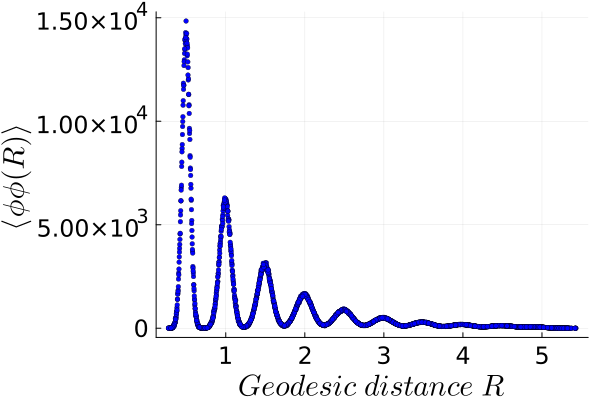

In [63]:
plot_correlation(distances, correlations; label="", color=:blue)
